© Copyright, 2026 G. Schaer.

SPDX-License-Identifier: GPL-3.0-only

# The Wheel Project

In this project, we will import a pre-made `condynsate` project, build a controller for it, run the project with our controller, and post-process the simulation data. The example project in this notebook is a wheel on an axle. The goal is to build a controller that makes the wheel point in a desired direction by applying torque to the axle.

## Importing the Project

The backend for this project has already been made for you. The backend will handle building the simulation environment, running and visualizing the simulation, applying your controller inputs, and tracking relevant data. Let's start off by importing this backend. It is a function named `run` that is stored in a Python script named `wheel.py`. 

In [1]:
# Import the project's backend.
from wheel import run

Now that we have the backend, we can make our own controller. In the scope of this project, the controller is implemented as function that takes as arguments some information about the wheel and returns the torque to apply to the wheel.

## A Proportional Controller

### Designing a Proportional Controller

In this case, we will implement a P (proportional) controller. This is a type of feedback controller that uses information about the process variable (the wheel's angle) and the set point (the target angle) to calculate what input (torque) to apply to the system. Specically, we calculate the error (the difference between the set point and the process variable) and set the input to be directly proportional to this error. In practice, we can implement this by multiplying the error by a constant, called the proportional gain, to get the input. Let's do this now.

In [2]:
def controller(angle, angular_rate, target):
    """
    The controller function. Given some state information, it calculates a torque that
    (hopefully) makes the wheel point at a target.

    Parameters
    ----------
    angle : float
        The current angle the wheel is facing in radians
    angular_rate : float
        The current angular rate of the wheel in radians / second
    target : float
        The current target angle in radians

    Returns
    -------
    torque : float
        The torque to apply to the wheel
    """
    kp = 0.25 # The proportional gain 
    error = (target - angle) # Calculate the error
    torque = kp * error # Calculate the input
    return torque

### Running the Proportional Controller
Now we are ready to run the simulation and collect data. To do this, we simply call the `run` function as pass as arguments the target wheel angle in radians and the controller function we just built. In this case, let's set the target angle to 90 degrees. The simulation will automatically run, apply our controller, and return to us some data collected during simulation. The data is a dictionary with the values:

`data['time']` : list of n floats

    The time, in seconds, at which each data point is collected
    
`data['angle']` : list of n floats

    The angle of the wheel, in radians, at each of the n data collection points.
    
`data['angular_rate']` : list of n floats

    The angular rate of the wheel, in radians per second, at each of the n data collection points.
    
`data['target']` : list of n floats

    The target angle, in radians, at each of the n data collection points.

`data['torque']` : list of n floats

    The torque applied to the wheel, in Newton-meters, at each of the n data collection points.

In [3]:
# Run the simulation and collect the simulation data
data = run(1.5708, controller)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Why didn't that work?

Because the controller apply inputs that are proportional to the error, whenever the wheel angle is less than the target angle, the torque is always positive. As a result, when the wheel approaches the target angle, no torque is applied to slow it down. This causes the wheel to overshoot the target angle flipping the error from positive to negative. The proportional controller reacts by applying negative torque in a similar manner again causing the wheel to overshoot. This process repeats back and forth resulting in the oscillations that you saw.

How might we correct this? 

As the wheel approaches the target angle, we should apply a torque that slows it down. To determine the best way to do this, let's look at the data collected from the simulation.

### Analyzing the Proportional Controller's Failure

Let's double check our intuition with a plot of the error and torque as functions of time.

In [76]:
# Import Numpy to assist with data analysis
import numpy as np

# Import plotting tool
import matplotlib.pyplot as plt
%matplotlib inline

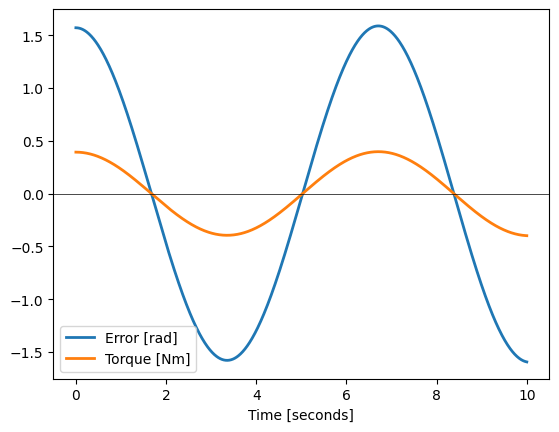

In [5]:
# Plot the error and torque as function of time
plt.plot(data['time'], data['target'] - data['angle'], label='Error [rad]', lw=2.0) 
plt.plot(data['time'], data['torque'], label='Torque [Nm]', lw=2.0)
plt.legend()
plt.xlabel('Time [seconds]')
plt.axhline(c='k', lw=0.5)
plt.show()

From this plot, our suspicions from above are confirmed. Indeed the torque is always positive when the error is positive and vice versa yielding the overshooting behavior. But what would happen if we also plotted the derivative of the error as a function of time? 

Recall, 
\begin{align}
e(t) = sp - pv(t)
\end{align}
where $e$ is the error, $sp$ is the set point, $pv$ is the process variable, and $t$ is time. Calculating the derivative of $e$ with respect to time, we find
\begin{align}
\frac{de(t)}{dt} &= \frac{sp}{dt} - \frac{pv(t)}{dt} \\
\frac{de(t)}{dt} &= -\frac{pv(t)}{dt}
\end{align}
So the derivative of the error is just the negated derivative of the process variable, i.e., the negated angular rate of the wheel. Let's plot this.

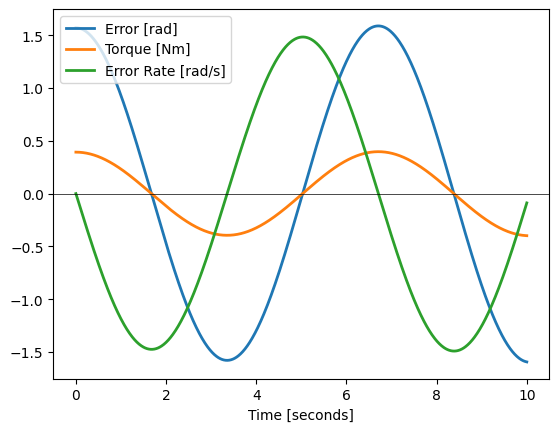

In [6]:
# Plot the error, derivative of the error, and torque as function of time
plt.plot(data['time'], data['target'] - data['angle'], label='Error [rad]', lw=2.0) 
plt.plot(data['time'], data['torque'], label='Torque [Nm]', lw=2.0)
plt.plot(data['time'], -data['angular_rate'], label='Error Rate [rad/s]', lw=2.0) 
plt.legend()
plt.xlabel('Time [seconds]')
plt.axhline(c='k', lw=0.5)
plt.show()

This looks promising. We see:
1. When the error is positive, the derivative of the error is negative.
2. When the error is 0, the derivative of the error is maximized.

This gives us a way to apply a torque slowing torque as the wheel approaches the target angle. All we have to do is apply another torque that is proportional to the derivative of the error. Let's implement this now.

## A Proportional Derivative Controller

### Designing a Proportional Derivative Controller

Let's implment a PD (proportional derivative) controller based on our insights from above. Just like before, we will build a controller that uses information about the process variable (the wheel's angle) and the set point (the target angle) to calculate what input (torque) to apply to the system. But in this case, we will also include the derivative of the process variable (the wheel's angular rate) in the torque calculation. Specically, we calculate the error (the difference between the set point and the process variable) and the derivative of the error (the negated derivative of the process variable) and set the input to be directly proportional to both the error and the derivative of the error. In practice, we can implement this by multiplying the error by a constant, called the proportional gain, multiplying the derivative of the error by a constant, called the derivative gain, and setting the input as the sum of these two values. Let's do this now.

In [7]:
def controller(angle, angular_rate, target):
    kp = 0.25 # The proportional gain 
    kd = 0.25 # The derivative gain
    error = (target - angle) # Calculate the error
    error_derivative = -angular_rate # Calculate the derivative of the error
    torque = kp * error + kd * error_derivative # Calculate the input
    return torque

### Running the Proportional Derivative Controller
Now we are again ready to run the simulation and collect data. To do this, we call the `run` function just like before, but this time with our new controller function.

In [8]:
# Run the simulation and collect the simulation data
data = run(1.5708, controller)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


### Visualizing the Proportional Derivative Controller's Success

That seems to have done it! Now as the wheel approaches the target angle, the influence of the derivative becomes larger and larger until eventually a stopping torque is applied. This starts to slow down the wheel and, whereas it still overshoots, it eventually settles on the target angle. Plotting this:

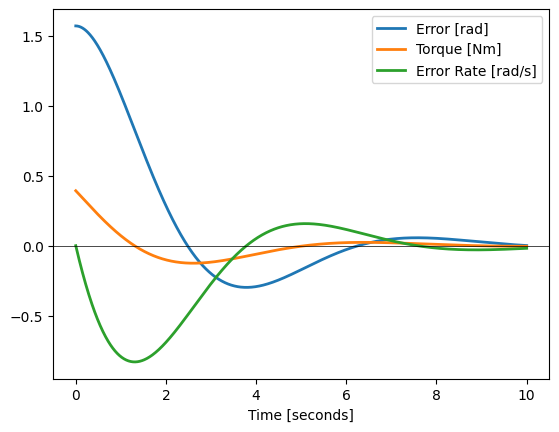

In [9]:
# Plot the error, derivative of the error, and torque as function of time
plt.plot(data['time'], data['target'] - data['angle'], label='Error [rad]', lw=2.0) 
plt.plot(data['time'], data['torque'], label='Torque [Nm]', lw=2.0)
plt.plot(data['time'], -data['angular_rate'], label='Error Rate [rad/s]', lw=2.0) 
plt.legend()
plt.xlabel('Time [seconds]')
plt.axhline(c='k', lw=0.5)
plt.show()

## Assignment

Now that we have a working controller, we will investigate how changes to the control gains alter its behavior. To do this, we alter the controller function, rerun the simulation, and investigate the results.

Rise time is defined as the time it takes for a state to change from a low value to a specified high value. For example, we can calculate the rise time of the wheel angle as the first time point at which the error hits 0. On the other hand, 5% settling time is defined as the amount of time it takes for a state to change from a low value to enter and remain within a 5% bound around a high value. For example, we can calculate the settling time of the wheel angle as the time point at which the wheel angle entered and remained within ±5% of the target.

    1. Calculate the rise and settling times of the previous simulation. Report your answers to the nearest tenth of a second.

    2. How do you expect changing the proportional gain would change the rise and settling times? Test your hypothesis by running a set of at least 3 simulations with altered proportional gains and plot the results. Discuss what changes you saw to the rise and settling times as a function of the proportional gain. Why did these results occur?

    3. How do you expect changing the derivative gain would change the rise and settling times? Test your hypothesis by running a set of at least 3 simulations with altered derivative gains and plot the results. Discuss what changes you saw to the rise and settling times as a function of the derivative gain. Why did these results occur?

    4. Why might an engineering want to reduce the rise time of a dynamic system? What detriments does decreasing the rise time have on the overall system response? How might these detriments be mitigated? Prove your claims via the simulation data collected from the above parts.

    5. Why might an engineering want to reduce the settling time of a dynamic system? What detriments does decreasing the settling time have on the overall system response? How might these detriments be mitigated? Again, prove your claims via the simulation data collected from the above parts.
